# Neste notebook faremos a simulação por dinâmica molecular do gás argônio superfluido à 94 K e 1 atm.

Antes de dar início à simulação, deveremos instalar o pacote M3L responsável pela dinâmica molecular. Descomente a linha abaixo caso ele ainda não foi instalado no seu ambiente virtual.

In [1]:
#pip install -i https://test.pypi.org/simple/ m3l --extra-index-url https://pypi.org/simple/

## Etapa 1
O primeiro passo consiste em definirmos o sistema físico contendo as coordenadas atômicas. Descomente as cinco primeiras linhas abaixo para fazer o download do arquivo "Ar_94K_1atm.json".

In [2]:
#url = 'https://raw.githubusercontent.com/flavianowilliams/M3L/development/src/notebooks/argon/Ar_94K_1atm.json'
#from urllib.request import urlopen
#file = urlopen(url)
#with open('Ar_94K_1atm.json','wb') as output:
#  output.write(file.read())
#
# carregando sistema físico
from m3l.structure import System as sys
import json
#
system = sys()
system.loadSystem('Ar_294K_1atm.json')
#
# convertendo as unidades de medida
system.convertUnits()

## Etapa 2
O segundo passo consiste em definirmos o modelo para o campo de força. Neste caso consideraremos uma molécula contendo apenas um sítio atômico com interações intermoleculares do tipo Van der Waals representado pela função Lennard-Jones de dois parâmetros, como mostra a figura abaixo.
![lennard-jones](../contrib/lennard-jones.jpeg)

In [3]:
# Etapa 2
# definindo o modelo de interação entre os átomos (campo de força)      
import m3l.force_field as ff
from m3l.force_field import Intermolecular as interff
class Forces(ff.ForceField):
    def __init__(self):
        super().__init__()
        self.structure(
            self.molecule(
                interff.site(1, 0.0, 0.2385, 3.4), #site ID, atomic charge, Lennard-Jones parameters
            )
        )
#        
model = Forces()
model()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 3.80200013e-04, 6.42506883e+00]])

## Etapa 3
O terceiro passo consiste em definir o modelo estatístico (ensemble canônico) que descreverá o sistema no equilíbrio termodinâmico.

In [4]:
# Etapa 3
# definindo o modelo estatístico (ensemble)
from m3l.molecular_dynamics import Ensemble as en
#
force_field = model()
ensemble = en(temp_bath = 294.4, press_bath = 1.0, timestep = 1.0e-3, force_field = force_field, pstat = 2.0)
system = ensemble(system)

## Etapa 4
O quarto passo consiste na dinâmica molecular, onde as coordenadas atômicas são recalculadas a cada passo da simulação em intervalos de tempo denominado de timestep. Opcionalmente o autor poderá registrar valores obtidos na simulação em arquivos de saída no formato csv.

In [5]:
# Etapa 4
# executando ciclo MD
import time
import csv
import numpy as np
#
n_steps = 500000
i_step = 0
start = time.time()
with open('history.csv', 'w', newline = '') as csvfile1, open('thermodynamics.csv', 'w', newline = '') as csvfile2:
    fieldnames1 = ['time', 'mass', 'x', 'y', 'z']
    writer1 = csv.DictWriter(csvfile1, fieldnames = fieldnames1)
    writer1.writeheader()
    fieldnames2 = ['time', 'volume', 'temperature', 'epotential', 'pressure']
    writer2 = csv.DictWriter(csvfile2, fieldnames = fieldnames2)
    writer2.writeheader()
    for step in range(n_steps):
        system = ensemble(system)
        if step%100 == 0:
            i_step += 1
            writer2.writerow({
                'time': ensemble.dtimestep*step/system.TIMECONV, 
                'volume': system.volume/system.ACONV**3,
                'temperature': system.temperature/system.TEMPCONV,
                'epotential': system.epotential/system.ECONV,
                'pressure': system.pressure/system.PCONV})
            for atom in system.atom:
                writer1.writerow({
                    'time': ensemble.dtimestep*step/system.TIMECONV,
                    'mass': atom[1],
                    'x': system.atom[4]/system.ACONV,
                    'y': system.atom[5]/system.ACONV,
                    'z': system.atom[6]/system.ACONV})
           #print(f'Step: {i_step}; Energy: {system.epotential*system.ECONV}')

end = time.time()
print(f'Elapsed time: {end - start} seconds')

Elapsed time: 1824.9896578788757 seconds


## Etapa 5
Esta etapa é opcional, onde o autor poderá salvar em um arquivo JSON o sistema físico obtido no final da simulação. Como opção, o autor poderá converter as unidades de medida em valores mais convenientes para a leitura e melhor interpretação do ponto de vista didático.

In [6]:
# Etapa opcional
# convertendo para as unidades de medida de entrada
system.convertUnitsInv()
#
# salvando sistema em arquivo JSON
system.save('Ar_294K_1atm.json')

## Etapa 6
Esta etapa é opcional, onde o autor poderá gerar gráficos das propriedades e analisar a sua evolução no tempo.

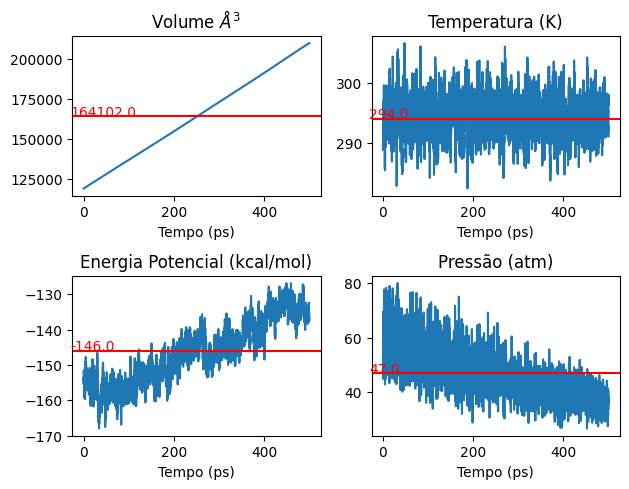

In [7]:
# Etapa opcional
# Gráfico de séries temporais de algumas variáveis termodinâmicas
import matplotlib.pyplot as plt
import numpy as np
dataset = np.loadtxt("thermodynamics.csv", dtype=np.float32, delimiter = ",", skiprows=1)
time = [item[0].item() for item in dataset]
vol = [item[1].item() for item in dataset]
temp = [item[2].item() for item in dataset]
epot = [item[3].item() for item in dataset]
press = [item[4].item() for item in dataset]
#plt.plot(time, temp)
fig, axs = plt.subplots(2, 2)
# volume
axs[0, 0].plot(time, vol)
axs[0, 0].set_title(r"Volume $\AA^3$")
yp = round(sum(vol)/len(vol), 0)
axs[0, 0].axhline(y = yp, color = 'red')
axs[0, 0].annotate(text = yp, xy = (0, yp), xytext = (-30, yp+5), color = 'r')
# temperatura
axs[0, 1].plot(time, temp)
axs[0, 1].set_title("Temperatura (K)")
yp = round(sum(temp)/len(temp), 0)
axs[0, 1].axhline(y = yp, color = 'red')
axs[0, 1].annotate(text = yp, xy = (0, yp), xytext = (-30, yp), color = 'r')
# Energia potencial
axs[1, 0].plot(time, epot)
axs[1, 0].set_title("Energia Potencial (kcal/mol)")
yp = round(sum(epot)/len(epot), 0)
axs[1, 0].axhline(y = yp, color = 'red')
axs[1, 0].annotate(text = yp, xy = (0, yp), xytext = (-30, yp), color = 'r')
# pressão
axs[1, 1].plot(time, press)
axs[1, 1].set_title("Pressão (atm)")
yp = round(sum(press)/len(press), 0)
axs[1, 1].axhline(y = yp, color = 'red')
axs[1, 1].annotate(text = yp, xy = (0, yp), xytext = (-30, yp), color = 'r')
#
fig.tight_layout()
for ax in axs.flat:
    ax.set(xlabel='Tempo (ps)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
fig.subplots_adjust(hspace = 0.5)
plt.savefig("MD.jpg")